In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Union, Dict
from scipy.special import binom

from metrics import r_squared, sum_squared_error, DurbinWatson
from metrics import RMSE, MAE, MAPE, Theil
from arma_tools import ARMA, AR, SMA, EMA
from metrics import ARMAEstimation

plt.style.use('seaborn-whitegrid')
np.set_printoptions(precision=6, suppress = True)
pd.options.display.float_format = '{:.6f}'.format

In [2]:
def ModelEstimation(y_true, y_pred):
    return pd.Series({
        'R-squared': r_squared(y_true, y_pred),
        'Sum squared resid': sum_squared_error(y_true, y_pred),
        'Durbin-Watson stat': DurbinWatson(y_pred - y_true),
    })

def PredictionEstimation(y_true, y_pred):
    N = len(y_pred)
    return pd.Series({
        'RMSE': RMSE(y_true, y_pred),
        'MAE': MAE(y_true, y_pred),
        'MAPE': MAPE(y_true, y_pred),
        'Theil': Theil(y_true, y_pred),
    })

## Завантаження даних

In [3]:
RSAFSNA = pd.read_csv('./lab4_data/RSAFSNA.txt', squeeze=True, header=None, names=['RSAFSNA'])
CURRNS = pd.read_csv('./lab4_data/CURRNS.txt', squeeze=True, header=None, names=['CURRNS'])

In [4]:
print(f'RSAFSNA length = {len(RSAFSNA)}')
print(f'CURRNS length = {len(CURRNS)}')

RSAFSNA length = 200
CURRNS length = 740


In [5]:
def train_test_split(series: pd.Series, test_size: Union[int, float]=0.2) -> (pd.Series, pd.Series):
    if type(test_size) is float:
        if test_size >=1 or test_size <= 0:
            raise ValueError('float test_size must be in range (0, 1)')
        train_len = int(len(series)*(1-test_size))
    elif type(test_size) is int:
        if test_size >= len(series) or test_size <=0:
            raise ValueError('int test_size must be in range (0, len(series))')
        train_len = len(series) - test_size
    else:
        raise ValueError('test_size must be int or float')
    train, test = series[:train_len], series[train_len:]
    train.name += ' train'
    test.name += ' test'
    return series[:train_len], series[train_len:]

In [6]:
RSAFSNA_train, RSAFSNA_test = train_test_split(RSAFSNA, test_size=8)
CURRNS_train, CURRNS_test = train_test_split(CURRNS, test_size=8)

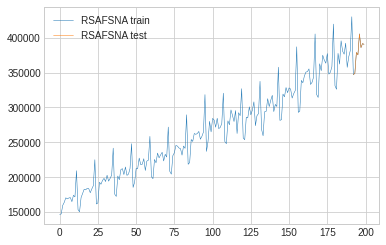

In [7]:
plt.plot(RSAFSNA, label='RSAFSNA train', linewidth=0.5)
plt.plot(RSAFSNA_test, label='RSAFSNA test', linewidth=0.5)
plt.legend()
plt.show()

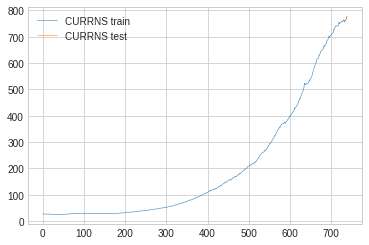

In [8]:
plt.plot(CURRNS, label='CURRNS train', linewidth=0.5)
plt.plot(CURRNS_test, label='CURRNS test', linewidth=0.5)
plt.legend()
plt.show()

Логарифмуємо дані

In [9]:
def log_series(series: pd.Series) -> pd.Series:
    res = np.log(series)
    res.name += ' LOG'
    return res

In [10]:
RSAFSNA_train_log, RSAFSNA_test_log = log_series(RSAFSNA_train), log_series(RSAFSNA_test)
CURRNS_train_log, CURRNS_test_log = log_series(CURRNS_train), log_series(CURRNS_test)

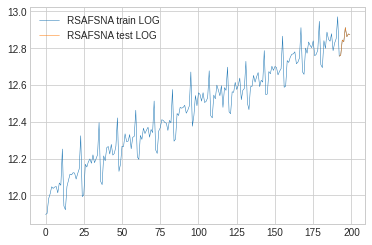

In [11]:
plt.plot(log_series(RSAFSNA), label='RSAFSNA train LOG', linewidth=0.5)
plt.plot(RSAFSNA_test_log, label='RSAFSNA test LOG', linewidth=0.5)
plt.legend()
plt.show()

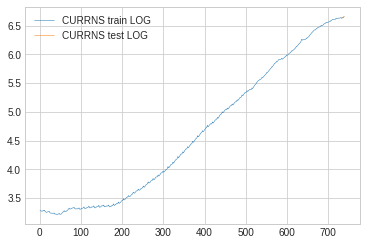

In [12]:
plt.plot(log_series(CURRNS), label='CURRNS train LOG', linewidth=0.5)
plt.plot(CURRNS_test_log, label='CURRNS test LOG', linewidth=0.5)
plt.legend()
plt.show()

## Моделі у вигляді тренду

In [13]:
def PolyFit(y: pd.Series, m: int) -> Dict[str, Union[np.array, pd.Series]]:
    """
    Fit polynomial model y(k) = a_0 + a_1*k + a_2*k^2 + ... + a_m*k^m
    """
    start_ind, stop_ind = y.index.start, y.index.stop
    Y = np.ones((len(y), m+1))
    for i in range(1, m+1):
        if i == 1:
            Y[:, i] = np.arange(start_ind, stop_ind)
        else:
            Y[:, i] = Y[:, 1]**i
    coefs = np.linalg.pinv(Y.T @ Y) @ Y.T @ y
    pred = pd.Series(Y @ coefs, pd.RangeIndex(start_ind, stop_ind))
    return {'actual': y,
            'fitted': pred,
            'coefficients': coefs,
            'residuals': y - pred}

def PolyPredict(y: pd.Series, m: int, coefs: np.array) -> pd.Series:
    """
    Predict using polynomial model y(k) = a_0 + a_1*k + a_2*k^2 + ... + a_m*k^m,
    a_i coefficients given in coefs
    """
    start_ind, stop_ind = y.index.start, y.index.stop
    Y = np.ones((len(y), m+1))
    if m+1 != len(coefs):
        raise ValueError('model order doesn\'t match coefs number')
    for i in range(1, m+1):
        if i == 1:
            Y[:, i] = np.arange(start_ind, stop_ind)
        else:
            Y[:, i] = Y[:, 1]**i
    pred = pd.Series(Y @ coefs, pd.RangeIndex(start_ind, stop_ind))
    return pred

### Ряд `RSAFSNA_train_log`

order = 1, equation: y(k) = 12.035758011242752 + 0.00437230387798695*k^1 
R-squared            0.915591
Sum squared resid    1.039491
Durbin-Watson stat   1.945355
dtype: float64
--------------------------------------------------
order = 2, equation: y(k) = 12.00500953730972 + 0.005343308319590453*k^1 - 5.083792890760554e-06*k^2 
R-squared            0.918632
Sum squared resid    1.002033
Durbin-Watson stat   2.018061
dtype: float64
--------------------------------------------------
order = 3, equation: y(k) = 11.973580512237895 + 0.007344073922126583*k^1 - 3.134032872323584e-05*k^2 + 9.164586652261704e-08*k^3 
R-squared            0.920974
Sum squared resid    0.973192
Durbin-Watson stat   2.076999
dtype: float64
--------------------------------------------------


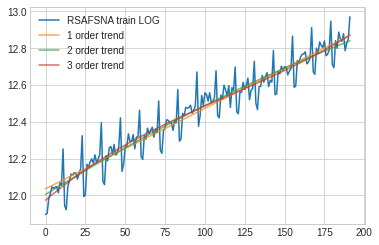

In [14]:
plt.plot(RSAFSNA_train_log, label='RSAFSNA train LOG')
for m in [1, 2, 3]:
    model = PolyFit(RSAFSNA_train_log, m)
    coef = model['coefficients']
    eq = f'y(k) = {coef[0]} '
    for i in range(1, m+1):
        eq += f'+ {coef[i]}*k^{i} ' if coef[i]>=0 else f'- {-coef[i]}*k^{i} '
    print(f'order = {m}, equation: {eq}')
    print(ModelEstimation(model['actual'].values, model['fitted'].values))
    print('-'*50)
    plt.plot(model['fitted'], label=f'{m} order trend', alpha=0.7)
plt.legend()
plt.show()

### Ряд `CURRNS_train_log`

order = 1, equation: y(k) = 2.6361819814155414 + 0.0053926247982546485*k^1 
R-squared             0.964580
Sum squared resid    34.902532
Durbin-Watson stat    0.001436
dtype: float64
--------------------------------------------------
order = 2, equation: y(k) = 3.0394885455408573 + 0.0020777763249028615*k^1 + 4.53467643462961e-06*k^2 
R-squared             0.988945
Sum squared resid    10.893677
Durbin-Watson stat    0.004413
dtype: float64
--------------------------------------------------
order = 3, equation: y(k) = 0.0003212993082751728 + 0.031336212517931186*k^1 - 7.19940312674098e-05*k^2 + 5.905273928576665e-08*k^3 
R-squared              1.886665
Sum squared resid    518.145966
Durbin-Watson stat     0.000275
dtype: float64
--------------------------------------------------


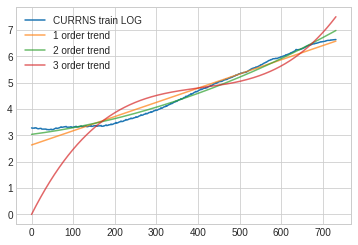

In [15]:
plt.plot(CURRNS_train_log, label='CURRNS train LOG')
for m in [1, 2, 3]:
    model = PolyFit(CURRNS_train_log, m)
    coef = model['coefficients']
    eq = f'y(k) = {coef[0]} '
    for i in range(1, m+1):
        eq += f'+ {coef[i]}*k^{i} ' if coef[i]>=0 else f'- {-coef[i]}*k^{i} '
    print(f'order = {m}, equation: {eq}')
    print(ModelEstimation(model['actual'].values, model['fitted'].values))
    print('-'*50)
    plt.plot(model['fitted'], label=f'{m} order trend', alpha=0.7)
plt.legend()

## Моделі АРІКС

In [16]:
def D(series: pd.Series, d: int) -> pd.Series:
    """
    Calculate d-th order difference on series
    """
    res = series.diff(d)
    if res.name is not None:
        res.name += f' diff {d}' 
    return res

def ARIMA(y: pd.Series, diff: pd.Series, d: int) -> pd.Series:
    """
    Calculate ARIMA fit of y series using predicted diff of order d
    """
    lag_coefs = [(-1)**(k)*int(binom(d, k)) for k in range(d+1)]
    start_ind = diff.index[0]
    fitted = diff.copy()
    for k in range(1, d+1):
        fitted -= lag_coefs[k] * y.shift(k)
    actual = y[start_ind:]
    return {'actual': actual,
            'fitted': fitted}

def ARIMA_forecast(forecast_size, forecast_type, y, model_params, d=1, test_set=None):
    """
    Forecast next values with ARMA(p, d, q)
    
    forecast_size   - number of values to forecast
    forecast_type   - 'static' or 'dynamic'
    y               - time series
    model_params    - dictionary ARMA's parameters
    d               - order of series differences
    test_set        - real values (for forecast_type='static' only)
    """
    y = y.copy()
    diff = D(y, d)
    model_params['y'] = diff
    estim = ARMA(**model_params)
    N = model_params['ma_window']
    p, q = estim['model_order']
    ma = estim['moving_average']
    if forecast_type == 'static':
        if len(test_set) < forecast_size: raise ValueError('len(test_set) < forecast_size')
        train_size = len(diff)
        y = y.append(test_set).copy()
        diff = D(y, d)
        ma = SMA(diff, N) if model_params['ma_type'] == 'sma' else EMA(diff, N)
        X = np.ones((forecast_size, p+q+1))
        for k in range(1, q+1):
            X[:, p+k] = ma.shift(k).iloc[-forecast_size:]
        for k in range(1, p+1):
            X[:, k] = diff.shift(k).iloc[-forecast_size:]
        diff_predict = X @ estim['coefficients']
        # выражаем y(k) из предикта
        for i in range(train_size, train_size+forecast_size):
            predict = diff_predict[i-train_size]
            if model_params['ma_type'] == 'sma':
                value = (N*predict + diff.iloc[i-N+1:i].sum()) / (N-1)
            if model_params['ma_type'] == 'ema':
                a = 2 / (N + 1)
                w = np.array([(1 - a)**n for n in range(N, 0, -1)])
                value = (sum(w)*predict + (diff.iloc[i-N+1:i]*w[:-1]).sum()) / sum(w[:-1])
            diff_predict[i-train_size] = value

    elif forecast_type == 'dynamic':
        for i in range(forecast_size):
            x = np.hstack([
                1, diff[::-1].iloc[:p], ma[::-1].iloc[:q]
            ])
            predict = x @ estim['coefficients']
            # в предикте y(k) - ma(k). Расписываем КС, решаем уравнение
            if model_params['ma_type'] == 'sma':
                value = (N*predict + diff.iloc[-N+1:].sum()) / (N-1)
                movav = (diff.iloc[-N+1:].sum() + value) / N
            if model_params['ma_type'] == 'ema':
                a = 2 / (N + 1)
                w = np.array([(1 - a)**n for n in range(N, 0, -1)])
                value = (sum(w)*predict + (diff.iloc[-N+1:]*w[:-1]).sum()) / sum(w[:-1])
                movav = ((diff.iloc[-N+1:]*w[:-1]).sum() + value*w[-1]) / sum(w)
       
            diff.at[len(diff)] = value
            ma.at[len(ma)] = movav
        diff_predict = diff.iloc[-forecast_size:].copy()
    else: raise ValueError('Unknown forecast type')
    
    # Интегрируем разницы
    lag_coefs = [(-1)**(k)*int(binom(d, k)) for k in range(d+1)]
    predict = np.asarray(diff_predict.copy())
    if forecast_type == 'dynamic':
        for i in range(len(predict)):
            predict[i] -= sum([lag_coefs[k] * y.iloc[-k] for k in range(1, d+1)])
            y.at[len(y)] = predict[i]

    if forecast_type == 'static':
        for i in range(len(predict)):
            predict[i] -= sum([lag_coefs[k] * y.iloc[train_size+i-k] for k in range(1, d+1)])
    
    y.iloc[-forecast_size:] = predict  # индексация
    diff.iloc[-forecast_size:] = diff_predict
    y.name += f' {forecast_type} forecast'
    diff.name += f' {forecast_type} forecast'
    return diff.iloc[-forecast_size:], y.iloc[-forecast_size:]

### АРКС для ряду, утворенного скінченними різницями `RSAFSNA_train_log`, та АРІКС для `RSAFSNA_train_log`

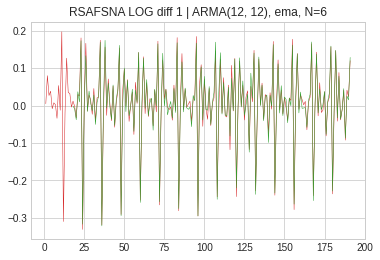

R-squared                 0.969446
Adjusted R-squared        0.964284
S.E. of regression        0.012824
Sum squared resid         0.028617
Log likelihood          598.119992
Durbin-Watson stat        1.985786
Mean dependent var        0.004942
S.D. dependent var        0.101716
Akaike info criterion    -6.587586
Schwarz criterion        -6.133699
dtype: float64


d[log[y(k)]] = 0.0067 - 0.6464*d[log[y(k-1)]] - 0.4543*d[log[y(k-2)]] - 0.2300*d[log[y(k-3)]] - 0.2266*d[log[y(k-4)]] - 0.1283*d[log[y(k-5)]] - 0.0120*d[log[y(k-6)]] - 0.0278*d[log[y(k-7)]] + 0.2033*d[log[y(k-8)]] - 0.5114*d[log[y(k-9)]] - 0.0140*d[log[y(k-10)]] - 0.2854*d[log[y(k-11)]] - 0.0164*d[log[y(k-12)]] + ma(k) - 0.3975*ma(k-1) - 0.2600*ma(k-2) - 0.1420*ma(k-3) - 0.1241*ma(k-4) - 0.0701*ma(k-5) - 0.0564*ma(k-6) - 0.0744*ma(k-7) - 0.7648*ma(k-8) + 1.9035*ma(k-9) - 1.1980*ma(k-10) + 0.7413*ma(k-11) + 1.2497*ma(k-12) 




NameError: name 'y_pred' is not defined

In [17]:
model_params = {
    'y': D(RSAFSNA_train_log, 1),
    'ma_window': 6,
    'ma_type': 'ema',
    'method': 'direct_2'
}
estim = ARMA(**model_params)
plt.plot(model_params['y'], label='Actual', color='tab:red', linewidth=0.5)
plt.plot(estim['fitted'], label='Fitted', color='tab:green', linewidth=0.5)
plt.title(f'{model_params["y"].name} | ARMA{estim["model_order"]}, {model_params["ma_type"]}, N={model_params["ma_window"]}')
plt.show()
print(ARMAEstimation(estim['actual'].values, estim['fitted'].values, estim['model_order']))
print('\n')

p, q = estim['model_order']
coef = estim['coefficients']
eq = f'd[log[y(k)]] = {coef[0]:.4f} '
for k in range(1, p+1):
    eq += f'+ {coef[k]:.4f}*d[log[y(k-{k})]] ' if coef[k]>=0 else f'- {-coef[k]:.4f}*d[log[y(k-{k})]] '
eq += '+ ma(k) '
for k in range(1, q+1):
    eq += f'+ {coef[p+k]:.4f}*ma(k-{k}) ' if coef[p+k]>=0 else f'- {-coef[p+k]:.4f}*ma(k-{k}) '
print(eq)
print('\n')

arima_params = {
    'y': RSAFSNA_train_log,
    'diff': estim['fitted'],
    'd': 1
}
arima_model = ARIMA(**arima_params)
plt.plot(arima_model['actual'], label='Actual', color='tab:red', linewidth=0.5)
plt.plot(arima_model['fitted'], label='Fitted', color='tab:green', linewidth=0.5)
plt.title(f'{arima_params["y"].name} | ARIMA({estim["model_order"][0]}, {estim["model_order"][1]}, {arima_params["d"]}), {model_params["ma_type"]}, N={model_params["ma_window"]}')

y_pred.plot()
RSAFSNA_test_log.plot()
plt.show()

print(ModelEstimation(arima_model['actual'].values, arima_model['fitted'].values))
print('\n')

#### Статичне прогнозування

In [302]:
diff, y_pred = ARIMA_forecast(8, 'static', RSAFSNA_train_log, model_params, test_set=RSAFSNA_test_log)
display(pd.DataFrame({'d log y':diff, 'log y':y_pred, 'true y':RSAFSNA_test_log}))
PredictionEstimation(RSAFSNA_test_log, y_pred)

,d log y,log y,true y
192,-0.206798,12.764633,12.756939
193,-0.008846,12.748093,12.762472
194,0.124981,12.887452,12.844645
195,-0.000982,12.843663,12.835747
196,0.096868,12.932616,12.912570
197,-0.040376,12.872194,12.862911
198,0.013350,12.876261,12.877761
199,0.035119,12.912880,12.874909


RMSE    0.022619
MAE     0.017699
MAPE    0.137737
Theil   0.000880
dtype: float64

#### Динамічне прогнозування

In [303]:
diff, y_pred = ARIMA_forecast(8, 'dynamic', RSAFSNA_train_log, model_params)
display(pd.DataFrame({'d log y':diff, 'log y':y_pred, 'true y':RSAFSNA_test_log}))
PredictionEstimation(RSAFSNA_test_log, y_pred)

,d log y,log y,true y
192,-0.206798,12.764633,12.756939
193,-0.015066,12.749567,12.762472
194,0.136293,12.885860,12.844645
195,-0.033703,12.852157,12.835747
196,0.084588,12.936744,12.912570
197,-0.045393,12.891351,12.862911
198,-0.004803,12.886549,12.877761
199,0.041926,12.928474,12.874909


RMSE    0.028577
MAE     0.024149
MAPE    0.187843
Theil   0.001112
dtype: float64

### АРКС для ряду, утворенного скінченними різницями `CURRNS_train_log`, та АРІКС для `CURRNS_train_log`

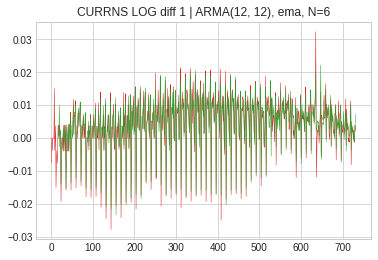

R-squared                  0.820512
Adjusted R-squared         0.813990
S.E. of regression         0.002474
Sum squared resid          0.004369
Log likelihood          3629.336285
Durbin-Watson stat         2.001384
Mean dependent var         0.004740
S.D. dependent var         0.007447
Akaike info criterion    -10.096180
Schwarz criterion         -9.936135
dtype: float64


d[log[y(k)]] = 0.0005 - 0.0438*d[log[y(k-1)]] - 0.1346*d[log[y(k-2)]] - 0.0186*d[log[y(k-3)]] - 0.1074*d[log[y(k-4)]] + 0.0155*d[log[y(k-5)]] - 0.0627*d[log[y(k-6)]] - 0.1138*d[log[y(k-7)]] + 0.7960*d[log[y(k-8)]] - 0.0158*d[log[y(k-9)]] + 0.6459*d[log[y(k-10)]] - 0.2306*d[log[y(k-11)]] + 0.7979*d[log[y(k-12)]] + ma(k) - 0.0646*ma(k-1) - 0.0773*ma(k-2) + 0.0027*ma(k-3) + 0.0114*ma(k-4) + 0.1050*ma(k-5) + 0.1258*ma(k-6) + 0.2538*ma(k-7) - 2.6556*ma(k-8) + 1.7262*ma(k-9) - 2.0807*ma(k-10) + 2.1958*ma(k-11) - 1.1771*ma(k-12) 




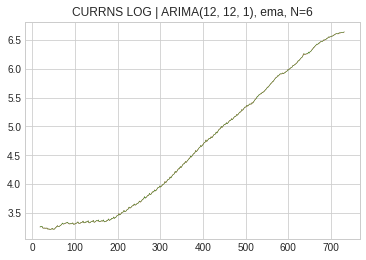

R-squared            0.999927
Sum squared resid    0.004369
Durbin-Watson stat   2.001384
dtype: float64




In [305]:
model_params = {
    'y': D(CURRNS_train_log, 1),
    'ma_window': 6,
    'ma_type': 'ema',
    'method': 'direct_2'
}
estim = ARMA(**model_params)
plt.plot(model_params['y'], label='Actual', color='tab:red', linewidth=0.5)
plt.plot(estim['fitted'], label='Fitted', color='tab:green', linewidth=0.5)
plt.title(f'{model_params["y"].name} | ARMA{estim["model_order"]}, {model_params["ma_type"]}, N={model_params["ma_window"]}')
plt.show()
print(ARMAEstimation(estim['actual'].values, estim['fitted'].values, estim['model_order']))
print('\n')

p, q = estim['model_order']
coef = estim['coefficients']
eq = f'd[log[y(k)]] = {coef[0]:.4f} '
for k in range(1, p+1):
    eq += f'+ {coef[k]:.4f}*d[log[y(k-{k})]] ' if coef[k]>=0 else f'- {-coef[k]:.4f}*d[log[y(k-{k})]] '
eq += '+ ma(k) '
for k in range(1, q+1):
    eq += f'+ {coef[p+k]:.4f}*ma(k-{k}) ' if coef[p+k]>=0 else f'- {-coef[p+k]:.4f}*ma(k-{k}) '
print(eq)
print('\n')

arima_params = {
    'y': CURRNS_train_log,
    'diff': estim['fitted'],
    'd': 1
}
arima_model = ARIMA(**arima_params)
plt.plot(arima_model['actual'], label='Actual', color='tab:red', linewidth=0.5)
plt.plot(arima_model['fitted'], label='Fitted', color='tab:green', linewidth=0.5)
plt.title(f'{arima_params["y"].name} | ARIMA({estim["model_order"][0]}, {estim["model_order"][1]}, {arima_params["d"]}), {model_params["ma_type"]}, N={model_params["ma_window"]}')
plt.show()

print(ModelEstimation(arima_model['actual'].values, arima_model['fitted'].values))
print('\n')

#### Статичне прогнозування

In [312]:
diff, y_pred = ARIMA_forecast(8, 'static', CURRNS_train_log, model_params, test_set=CURRNS_test_log)
display(pd.DataFrame({'d log y':diff, 'log y':y_pred, 'true y':CURRNS_test_log}))
PredictionEstimation(CURRNS_test_log, y_pred)

,d log y,log y,true y
732,-0.008619,6.629687,6.627247
733,0.001911,6.629159,6.631606
734,0.003135,6.634742,6.635815
735,0.002322,6.638137,6.632924
736,0.000903,6.633827,6.638437
737,0.001602,6.640039,6.644831
738,0.004074,6.648904,6.652605
739,0.001382,6.653987,6.653379


RMSE    0.003510
MAE     0.003111
MAPE    0.046854
Theil   0.000264
dtype: float64

#### Динамічне прогнозування

In [313]:
diff, y_pred = ARIMA_forecast(8, 'dynamic', CURRNS_train_log, model_params)
display(pd.DataFrame({'d log y':diff, 'log y':y_pred, 'true y':CURRNS_test_log}))
PredictionEstimation(CURRNS_test_log, y_pred)

,d log y,log y,true y
732,-0.008619,6.629687,6.627247
733,0.002531,6.632218,6.631606
734,0.002645,6.634863,6.635815
735,0.002211,6.637074,6.632924
736,0.001878,6.638951,6.638437
737,0.000919,6.639871,6.644831
738,0.003079,6.642950,6.652605
739,-0.000606,6.642344,6.653379


RMSE    0.005748
MAE     0.004290
MAPE    0.064543
Theil   0.000433
dtype: float64

## Моделі АР

### Ряд `RSAFSNA_train_log`

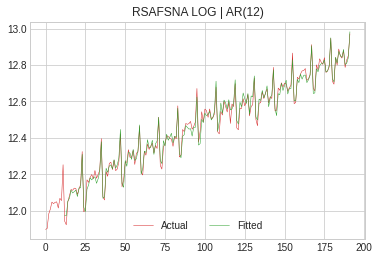

R-squared            0.990408
Sum squared resid    0.095208
Durbin-Watson stat   1.232288
dtype: float64


log[y(k)] = 0.3738 + 0.0078*log[y(k-1)] + 0.0041*log[y(k-2)] + 0.0315*log[y(k-3)] - 0.0041*log[y(k-4)] + 0.0413*log[y(k-5)] + 0.0011*log[y(k-6)] + 0.0014*log[y(k-7)] + 0.0081*log[y(k-8)] - 0.0109*log[y(k-9)] - 0.0368*log[y(k-10)] - 0.0023*log[y(k-11)] + 0.9327*log[y(k-12)] 


In [20]:
model_params = {
    'y': RSAFSNA_train_log
}
estim = AR(**model_params)
plt.plot(model_params['y'], label='Actual', color='tab:red', linewidth=0.5)
plt.plot(estim['fitted'], label='Fitted', color='tab:green', linewidth=0.5)
plt.title(f'{model_params["y"].name} | AR({estim["model_order"][0]})')
plt.legend(loc='lower center', ncol=2)
plt.show()
print(ModelEstimation(estim['actual'].values, estim['fitted'].values))
print('\n')

p = estim['model_order'][0]
coef = estim['coefficients']
eq = f'log[y(k)] = {coef[0]:.4f} '
for k in range(1, p+1):
    eq += f'+ {coef[k]:.4f}*log[y(k-{k})] ' if coef[k]>=0 else f'- {-coef[k]:.4f}*log[y(k-{k})] '
print(eq)

### Ряд `CURRNS_train_log`

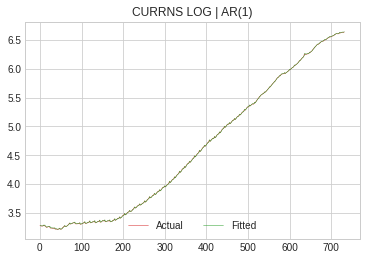

R-squared            0.999951
Sum squared resid    0.048246
Durbin-Watson stat   1.768312
dtype: float64


log[y(k)] = -0.0009 + 1.0012*log[y(k-1)] 


In [21]:
model_params = {
    'y': CURRNS_train_log
}
estim = AR(**model_params)
plt.plot(model_params['y'], label='Actual', color='tab:red', linewidth=0.5)
plt.plot(estim['fitted'], label='Fitted', color='tab:green', linewidth=0.5)
plt.title(f'{model_params["y"].name} | AR({estim["model_order"][0]})')
plt.legend(loc='lower center', ncol=2)
plt.show()
print(ModelEstimation(estim['actual'].values, estim['fitted'].values))
print('\n')

p = estim['model_order'][0]
coef = estim['coefficients']
eq = f'log[y(k)] = {coef[0]:.4f} '
for k in range(1, p+1):
    eq += f'+ {coef[k]:.4f}*log[y(k-{k})] ' if coef[k]>=0 else f'- {-coef[k]:.4f}*log[y(k-{k})] '
print(eq)

## Моделі АРКС

### Ряд `RSAFSNA_train_log`

R-squared            0.991449
Sum squared resid    0.042806
Durbin-Watson stat   1.232288
dtype: float64


log[y(k)] = 0.2507 - 0.1936*log[y(k-1)] - 0.1177*log[y(k-2)] - 0.0649*log[y(k-3)] - 0.0642*log[y(k-4)] - 0.0162*log[y(k-5)] + 0.0131*log[y(k-6)] + 0.0049*log[y(k-7)] + 0.0054*log[y(k-8)] - 0.0073*log[y(k-9)] - 0.0247*log[y(k-10)] - 0.0015*log[y(k-11)] + 0.6254*log[y(k-12)] + ma(k) - 0.1107*ma(k-1) - 0.0654*ma(k-2) 


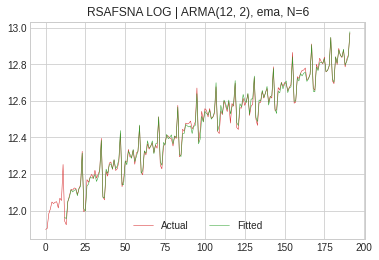

In [22]:
model_params = {
    'y': RSAFSNA_train_log,
    'ma_window': 6,
    'ma_type': 'ema',
    'method': 'direct_2',
}
estim = ARMA(**model_params)
plt.plot(model_params['y'], label='Actual', color='tab:red', linewidth=0.5)
plt.plot(estim['fitted'], label='Fitted', color='tab:green', linewidth=0.5)
plt.title(f'{model_params["y"].name} | ARMA{estim["model_order"]}, {model_params["ma_type"]}, N={model_params["ma_window"]}')
plt.legend(loc='lower center', ncol=2)
print(ModelEstimation(estim['actual'].values, estim['fitted'].values))
print('\n')

p, q = estim['model_order']
coef = estim['coefficients']
eq = f'log[y(k)] = {coef[0]:.4f} '
for k in range(1, p+1):
    eq += f'+ {coef[k]:.4f}*log[y(k-{k})] ' if coef[k]>=0 else f'- {-coef[k]:.4f}*log[y(k-{k})] '
eq += '+ ma(k) '
for k in range(1, q+1):
    eq += f'+ {coef[p+k]:.4f}*ma(k-{k}) ' if coef[p+k]>=0 else f'- {-coef[p+k]:.4f}*ma(k-{k}) '
print(eq)

### Ряд `CURRNS_train_log`

R-squared            0.999958
Sum squared resid    0.020567
Durbin-Watson stat   1.900129
dtype: float64


log[y(k)] = -0.0004 + 0.2368*log[y(k-1)] + ma(k) + 0.7614*ma(k-1) - 1.4600*ma(k-2) + 0.4626*ma(k-3) 


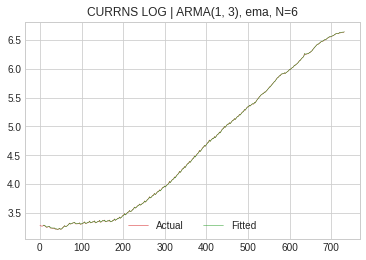

In [23]:
model_params = {
    'y': CURRNS_train_log,
    'ma_window': 6,
    'ma_type': 'ema',
    'method': 'direct_2'
}
estim = ARMA(**model_params)
plt.plot(model_params['y'], label='Actual', color='tab:red', linewidth=0.5)
plt.plot(estim['fitted'], label='Fitted', color='tab:green', linewidth=0.5)
plt.title(f'{model_params["y"].name} | ARMA{estim["model_order"]}, {model_params["ma_type"]}, N={model_params["ma_window"]}')
plt.legend(loc='lower center', ncol=2)
print(ModelEstimation(estim['actual'].values, estim['fitted'].values))
print('\n')

p, q = estim['model_order']
coef = estim['coefficients']
eq = f'log[y(k)] = {coef[0]:.4f} '
for k in range(1, p+1):
    eq += f'+ {coef[k]:.4f}*log[y(k-{k})] ' if coef[k]>=0 else f'- {-coef[k]:.4f}*log[y(k-{k})] '
eq += '+ ma(k) '
for k in range(1, q+1):
    eq += f'+ {coef[p+k]:.4f}*ma(k-{k}) ' if coef[p+k]>=0 else f'- {-coef[p+k]:.4f}*ma(k-{k}) '
print(eq)

### Статичне прогнозування

In [24]:
model = PolyFit(RSAFSNA_train_log, 1)
pred = PolyPredict(RSAFSNA_test_log, 1, model['coefficients'])
print(pd.DataFrame({'actual': RSAFSNA_test_log,
              'predicted': pred}))
PredictionEstimation(RSAFSNA_test_log, pred)

       actual  predicted
192 12.756939  12.875240
193 12.762472  12.879613
194 12.844645  12.883985
195 12.835747  12.888357
196 12.912570  12.892730
197 12.862911  12.897102
198 12.877761  12.901474
199 12.874909  12.905846


RMSE    0.066252
MAE     0.054509
MAPE    0.425656
Theil   0.002575
dtype: float64

In [25]:
model = PolyFit(CURRNS_train_log, 1)
pred = PolyPredict(CURRNS_test_log, 1, model['coefficients'])
print(pd.DataFrame({'actual': CURRNS_test_log,
              'predicted': pred}))
PredictionEstimation(CURRNS_test_log, pred)

      actual  predicted
732 6.627247   6.583583
733 6.631606   6.588976
734 6.635815   6.594369
735 6.632924   6.599761
736 6.638437   6.605154
737 6.644831   6.610546
738 6.652605   6.615939
739 6.653379   6.621332


RMSE    0.037410
MAE     0.037148
MAPE    0.559550
Theil   0.002825
dtype: float64